In [2]:
from skimage.io import imread_collection
import cv2
import numpy as np
from keras.utils import np_utils 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



def load_data(path):
    #creating a collection with the available images
    image = imread_collection(path)
    image_set = []
    for n in image:
        n = cv2.cvtColor(n,cv2.COLOR_RGB2GRAY)
        image_set.append(n)
    return image_set

Using TensorFlow backend.


In [3]:
data_set = load_data('original/*.jpg')

In [2]:
def process_image(image_set, size, margin):
    data = []
    for n in image_set:
        n = n[margin[0]:margin[1], margin[2]:margin[3]]
#         n = cv2.resize(n,(size,size))
        n = n / 255
        data.append(n)
    return data
    
def set_init(dataset, train_set_ratio, valid_set_ratio, test_set_ratio):

    
    #creating label set for all images
    label = np.empty(195*4)
    for i in range(195):
        label[i*4:i*4+4] = i
    label = label.astype(np.int)
    label = np_utils.to_categorical(label, 195)#transfer to one-hot matrix
    
    train_num = 780*train_set_ratio
    train_num = int(train_num)
    valid_num = 780*valid_set_ratio
    valid_num = int(valid_num)
    test_num = 780*test_set_ratio
    test_num = int(test_num)
    
    train_data = np.empty((train_num,200,200))  
    train_label = np.empty((train_num,195))   
    valid_data = np.empty((valid_num, 200,200))   
    valid_label = np.empty((valid_num,195))   
    test_data = np.empty((test_num,200,200))  
    test_label = np.empty((test_num,195)) 
    
    x_test_tot = np.empty((valid_num + test_num,200,200))
    y_test_tot = np.empty((valid_num + test_num,195))
    
    train_data, x_test_tot, train_label, y_test_tot = train_test_split(dataset, label, test_size = 1-train_set_ratio)
    
    valid_data, test_data, valid_label, test_label = train_test_split(x_test_tot, y_test_tot, test_size = test_set_ratio/(valid_set_ratio + test_set_ratio))
    
    train_data = np.asarray(train_data)
    valid_data = np.asarray(valid_data)
    test_data = np.asarray(test_data)
#     for i in range(195):
#         train_data[i * 2:i * 2 + 2] = image_set[i * 4:i * 4 + 2]
#         train_label[i * 2:i * 2 + 2] = label[i * 4:i * 4 + 2]
#         valid_data[i] = image_set[i * 4 + 2]
#         valid_label[i] = label[i * 4 + 2]
#         test_data[i] = image_set[i * 4 + 3]
#         test_label[i] = label[i * 4 + 3]
    result = [(train_data, train_label), (valid_data, valid_label),(test_data, test_label)]
   
    return result

In [3]:
data = process_image(data_set, size = 200, margin = [500,2500,500,3500])
data = set_init(data, train_set_ratio = 0.8, valid_set_ratio = 0.1, test_set_ratio = 0.1)

NameError: name 'data_set' is not defined

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from keras import regularizers

def train(data, batch_size, epochs, nb_filters, pool_size, kernel_size):
    np.random.seed(1337)  # for reproducibility
    img_rows, img_cols = 200, 200  # 输入图片样本的宽高
    nb_classes = 195  # 分类数目
    input_shape = (img_rows, img_cols,1)  # 输入图片的维度

    [(X_train, Y_train), (X_valid, Y_valid),(X_test, Y_test)] = data
    X_train = X_train[:,:,:,np.newaxis]  # 添加一个维度，代表图片通道。这样数据集共4个维度，样本个数、宽度、高度、通道数
    X_valid=X_valid[:,:,:,np.newaxis]  # 添加一个维度，代表图片通道。这样数据集共4个维度，样本个数、宽度、高度、通道数
    X_test=X_test[:,:,:,np.newaxis]  # 添加一个维度，代表图片通道。这样数据集共4个维度，样本个数、宽度、高度、通道数
    print('样本数据集的维度：', X_train.shape,Y_train.shape)
    print('测试数据集的维度：', X_test.shape,Y_test.shape)
    model = Sequential()
    model.add(Conv2D(6,kernel_size,padding = 'same', input_shape=input_shape,strides=1))  # 卷积层1
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size,strides=2))  # 池化层
    model.add(Conv2D(12,kernel_size,strides=1))  # 卷积层2
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size,strides=2))  # 池化层
    model.add(Flatten())  # 拉成一维数据
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes)) # 全连接层2, kernel_regularizer=regularizers.l2(0.05)
    model.add(Activation('sigmoid'))  # softmax评分
    
#     # this is the augmentation configuration we will use for training
#     train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         zoom_range=0.2,
#         horizontal_flip=True)

#     # this is the augmentation configuration we will use for testing:
#     # only rescaling
#     test_datagen = ImageDataGenerator(rescale=1./255)

#     # this is a generator that will read pictures found in
#     # subfolers of 'data/train', and indefinitely generate
#     # batches of augmented image data
#     train_generator = train_datagen.flow_from_directory(
#         'original',  # this is the target directory
#         target_size=(150, 150),  # all images will be resized to 150x150
#         batch_size=batch_size,
#         color_mode="gray",
#         class_mode="categorical",
#         shuffle=True,
#         seed=42)  # since we use binary_crossentropy loss, we need binary labels

#     # this is a similar generator, for validation data
#     validation_generator = test_datagen.flow_from_directory(
#         'original',
#         target_size=(150, 150),
#         batch_size=batch_size,
#         color_mode="gray",
#         class_mode="categorical",
#         shuffle=True,
#         seed=42)

    # 编译模型
    model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
    # 训练模型
    model.fit(X_train, Y_train, batch_size, epochs,verbose=1, validation_data=(X_valid, Y_valid))
    
    
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

    
    
    
    y_train_out = model.predict(X_train)
    y_train_out = y_train_out.argmax(axis=1)
    for i in range(len(y_train_out)):
    #     oneimg = X_test[i,:,:,0]*256
    #     im = Image.fromarray(oneimg)
    #     im.show()
        print('train: 第%d个人识别为第%d个人'%(Y_train.argmax(axis=1).item(i),y_train_out[i]))
        

    y_pred = model.predict(X_test)
    y_pred = y_pred.argmax(axis=1)   # 获取概率最大的分类，获取每行最大值所在的列
    for i in range(len(y_pred)):
    #     oneimg = X_test[i,:,:,0]*256
    #     im = Image.fromarray(oneimg)
    #     im.show()
        print('第%d个人识别为第%d个人'%(Y_test.argmax(axis=1).item(i),y_pred[i]))

Using TensorFlow backend.


In [4]:
train(data, batch_size = 20,epochs = 60, nb_filters = 64, pool_size = 6, kernel_size = 9)

NameError: name 'data' is not defined

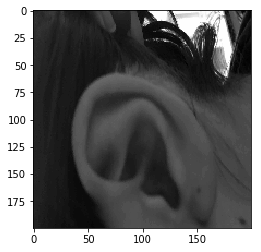

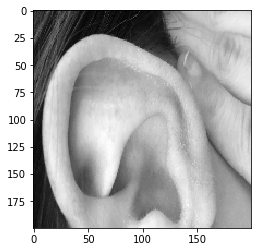

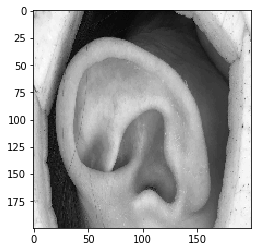

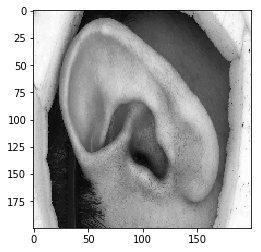

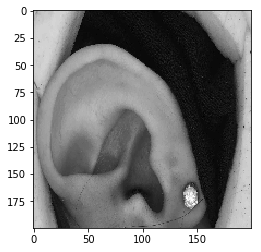

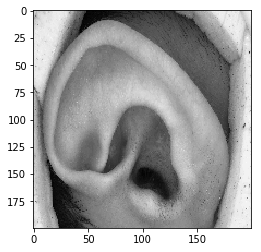

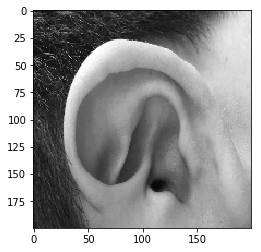

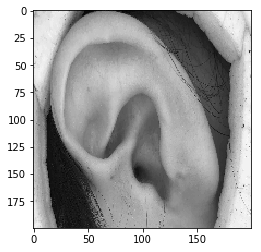

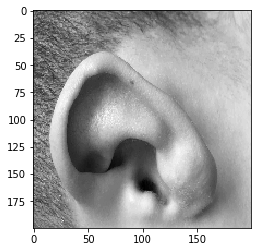

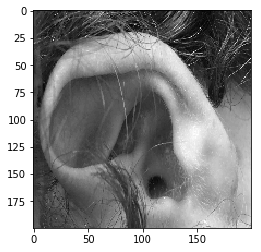

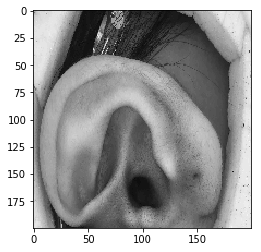

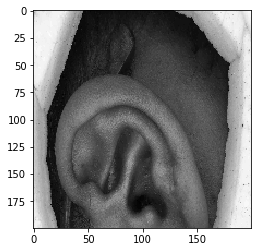

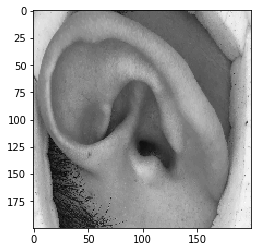

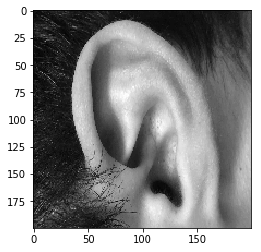

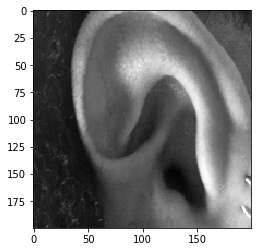

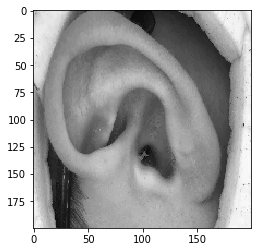

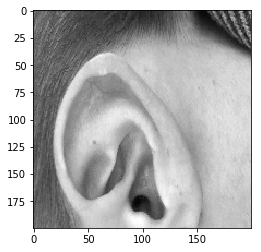

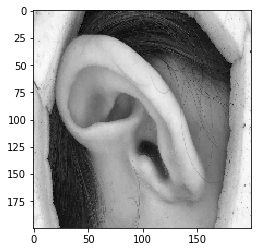

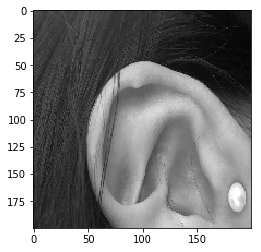

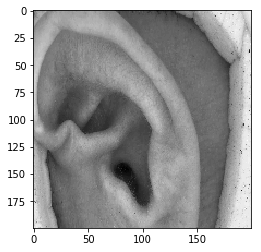

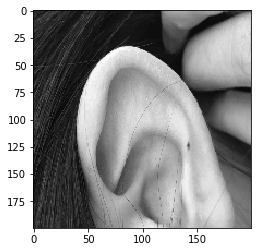

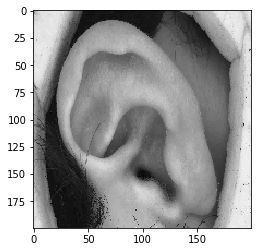

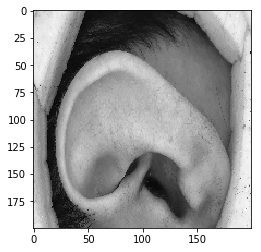

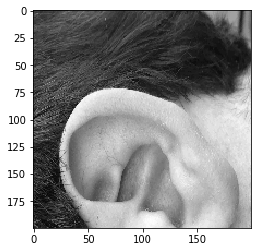

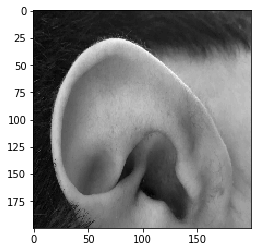

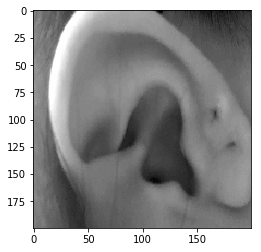

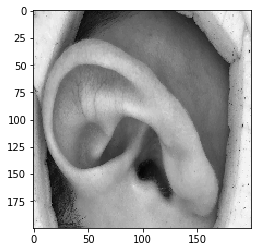

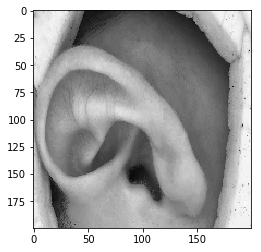

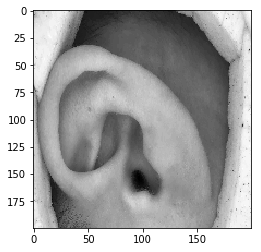

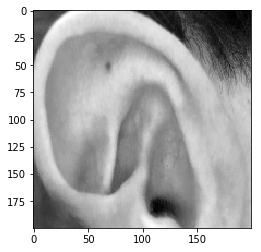

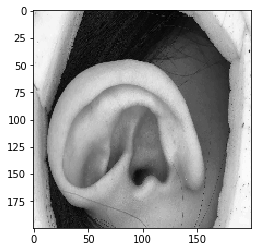

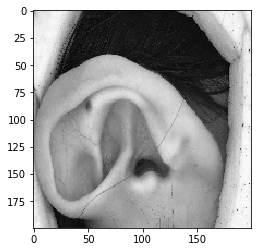

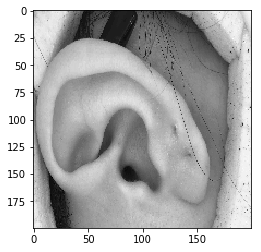

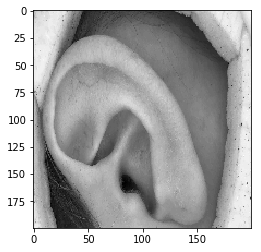

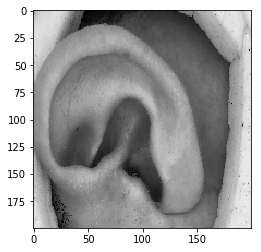

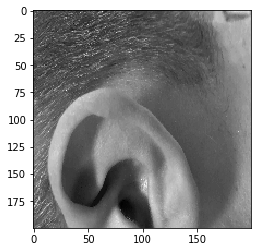

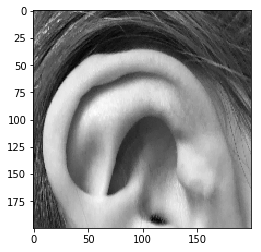

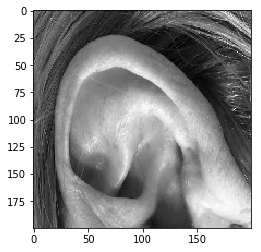

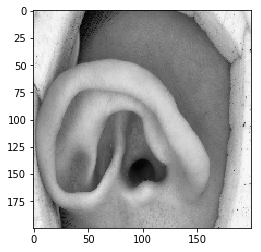

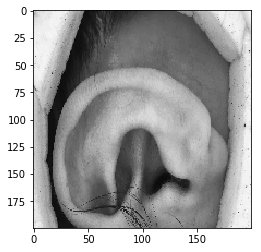

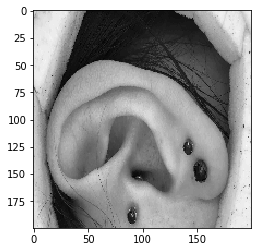

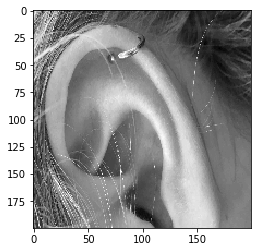

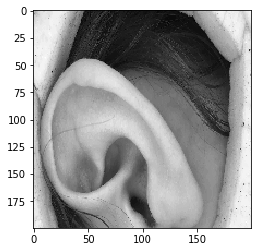

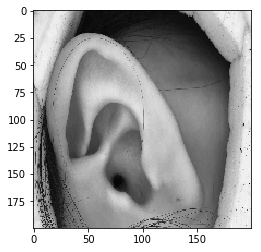

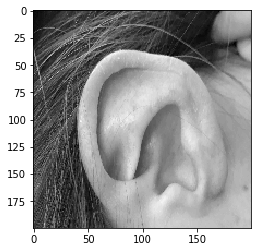

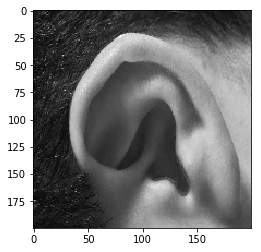

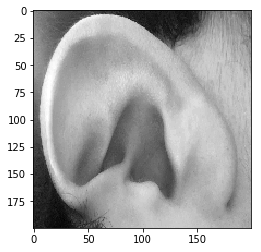

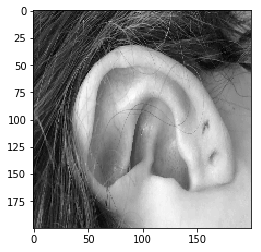

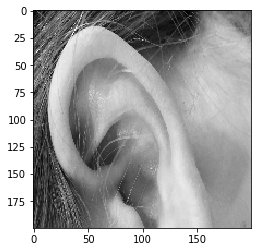

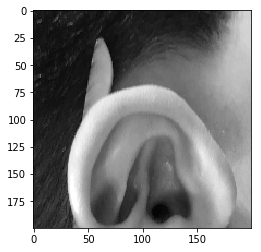

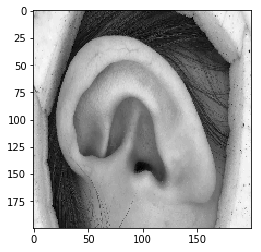

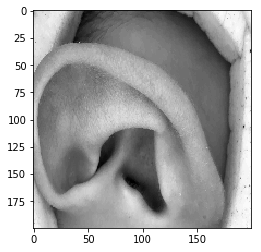

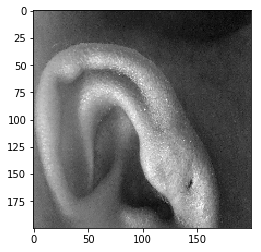

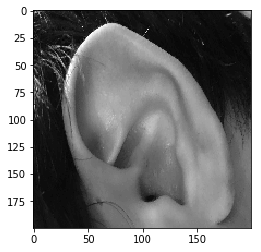

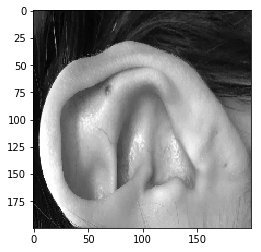

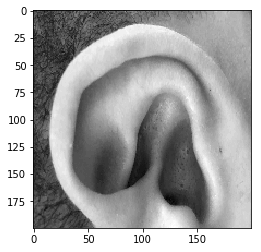

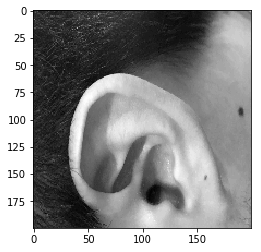

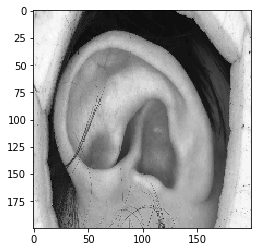

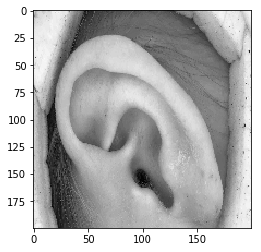

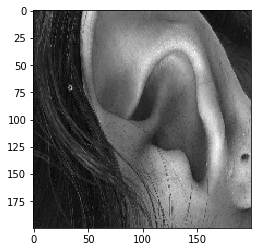

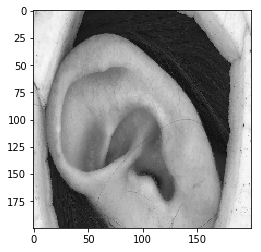

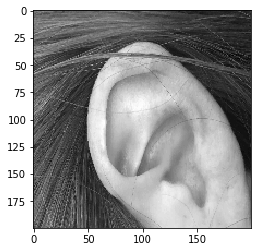

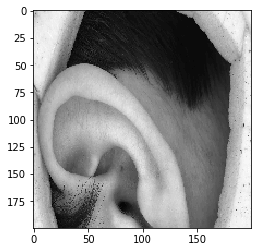

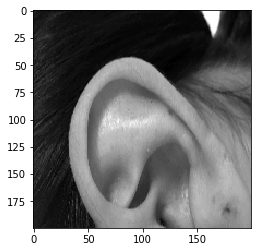

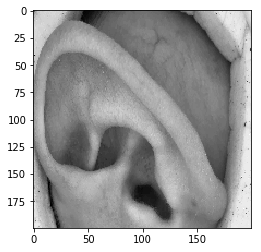

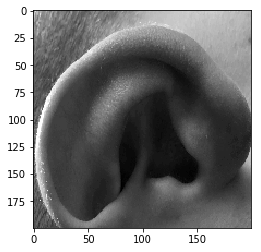

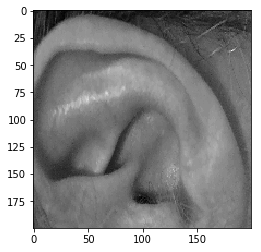

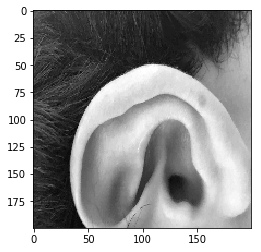

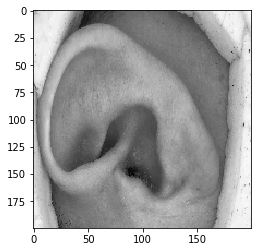

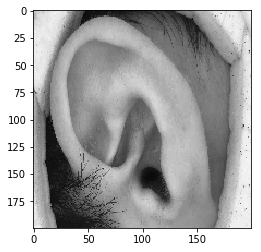

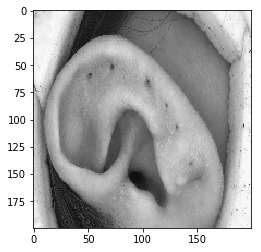

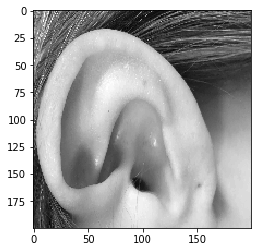

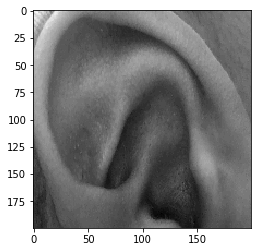

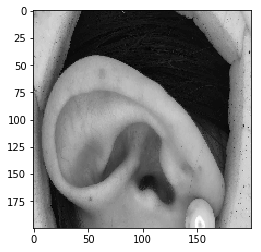

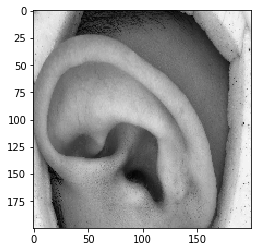

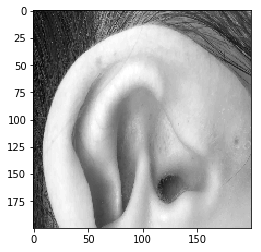

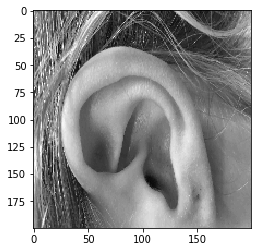

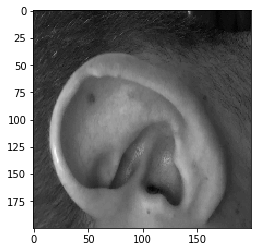

In [101]:
[(X_train, Y_train), (X_valid, Y_valid),(X_test, Y_test)] = data
for i in X_valid:
    plt.imshow(i, cmap='gray')
    plt.show()

(200, 200)


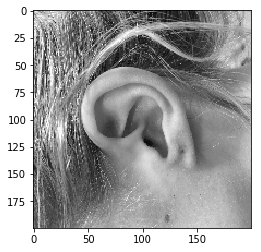

In [58]:


image = data_set[0]
print(image.shape)

# plt.imshow(image)
# plt.show()

plt.imshow(image, cmap='gray')
plt.show()

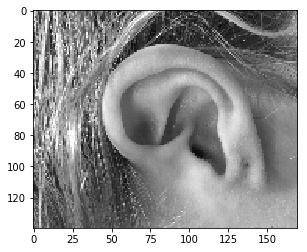

In [73]:
cropped_image = image[30:170, 0:170]
plt.imshow(cropped_image, cmap='gray')
plt.show()

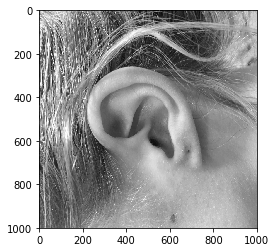

[[173 179 179 ... 181 183 183]
 [204 177 189 ... 176 184 184]
 [227 204 197 ... 172 171 171]
 ...
 [110  92 115 ... 135 143 140]
 [ 98  86 123 ... 135 139 144]
 [ 99  98 133 ... 135 134 149]]
(1000, 1000)


In [5]:
resized_image = cv2.resize(image, (1000,1000 ))
plt.imshow(resized_image, cmap='gray')
plt.show()
print(resized_image)
print(resized_image.shape)

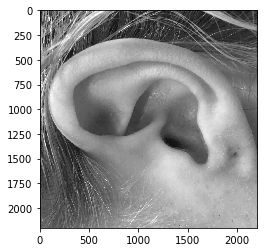

[[122 124 126 ...  87  87  87]
 [128 130 133 ...  84  84  84]
 [135 137 139 ...  81  81  81]
 ...
 [122 126 133 ... 188 188 188]
 [126 130 136 ... 188 188 188]
 [129 133 139 ... 188 188 188]]
(2200, 2200)


In [16]:
crop_img = image[500:2700,800:3000]
plt.imshow(crop_img, cmap='gray')
plt.show()
print(crop_img)
print(crop_img.shape)


In [17]:
for ear in train_x1:
    ear = cv2.cvtColor(ear,cv2.COLOR_RGB2GRAY)

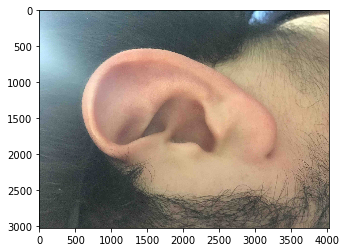

(3024, 4032, 3)


In [19]:
plt.imshow(train_x1[145],cmap = 'gray')
plt.show()
print(train_x1[145].shape)

In [5]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

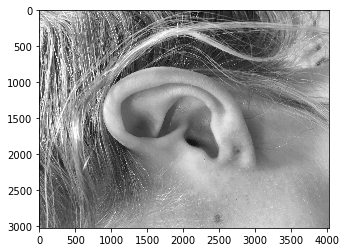

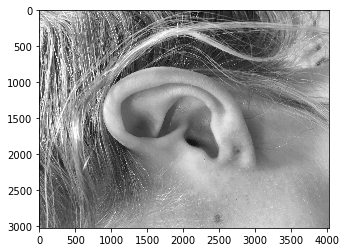

In [15]:
plt.imshow(data_set[0], cmap = 'gray')
plt.show()
image = adjust_gamma(data_set[0],1)
plt.imshow(image,cmap = 'gray')
plt.show()